# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_ForecastingTrader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.6.0'

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *

import pandas as pd
import pickle
import time
import sys
import json
import os

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, TimeDistributed
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

In [4]:
config_file = 'config/config_commodities_2010_2019.json'

In [5]:
pd.__version__

'0.24.2'

### Import Configurations

In [6]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [1073]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1074]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [10]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')

# inter day
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [11]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values


In [12]:
len(df_prices_train)+len(df_prices_test)

195414

# Load Pairs

In [271]:
# intraday
n_years_train = round(len(df_prices_train)/(240*78))

# interday
#n_years_train = round(len(df_prices_train)/(240))

n_years_train

train_val_split = '2017-01-01'

# The ideal scenario - forecasting accuracy of 100%

In [932]:
# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date
cumret_pairs = []    
summaries = []
val=True
for i in range(len(pairs)):
    example = pairs[i]
    example_spread = example[2]['spread']

    if val:
        # spread validation
        spread_val = example_spread[train_val_split:] 
    else:
        spread_val = pairs[i][2]['Y_test']-pairs[i][2]['coint_coef']*pairs[i][2]['X_test']

    ret_example, cumret_example, summary_example, _ = forecasting_trader.spread_trading(
                                                                       X=example[2]['X_train'][train_val_split:],
                                                                       Y=example[2]['Y_train'][train_val_split:],
                                                                       spread_test=spread_val,
                                                                       spread_train=example_spread[:train_val_split],
                                                                       beta=pairs[i][2]['coint_coef'], 
                                                                       predictions=spread_val,
                                                                       lag=1,
                                                                       low_quantile=0.05,
                                                                       high_quantile=0.95)
    print('Pair {}: Accumulated return: {}%'.format(i,cumret_example[-1]*100))
    cumret_pairs.append(cumret_example[-1]*100)
    summaries.append(summary_example)
    #cumret_example.plot()
print('\nAverage annual ROI: {:.2f}'.format(np.mean(cumret_pairs)))

Long threshold: 0.23
Short threshold: -0.24
Accuracy of time series forecasting: 100.00%
Pair 0: Accumulated return: 10.723356019812048%
Long threshold: 0.07
Short threshold: -0.07
Accuracy of time series forecasting: 100.00%
Pair 1: Accumulated return: -3.756966799459527%
Long threshold: 0.03
Short threshold: -0.03
Accuracy of time series forecasting: 100.00%
Pair 2: Accumulated return: 17.239328571588896%
Long threshold: 0.03
Short threshold: -0.03
Accuracy of time series forecasting: 100.00%
Pair 3: Accumulated return: 5.6362617280037774%
Long threshold: 0.09
Short threshold: -0.09
Accuracy of time series forecasting: 100.00%
Pair 4: Accumulated return: 32.47421415939109%

Average annual ROI: 12.46


In [933]:
# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date
cumret_pairs = []    
summaries = []
val=False
for i in range(len(pairs)):
    example = pairs[i]
    example_spread = example[2]['spread']

    if val:
        # spread validation
        spread_val = example_spread[train_val_split:] 
    else:
        spread_val = pairs[i][2]['Y_test']-pairs[i][2]['coint_coef']*pairs[i][2]['X_test']

    ret_example, cumret_example, summary_example, _ = forecasting_trader.forecast_spread_trading(
                                                                       X=example[2]['X_test'],
                                                                       Y=example[2]['Y_test'],
                                                                       spread_test=spread_val,
                                                                       spread_train=example_spread[:train_val_split],
                                                                       beta=pairs[i][2]['coint_coef'], 
                                                                       predictions=spread_val,
                                                                       lag=1,
                                                                       low_quantile=0.05,
                                                                       high_quantile=0.95)
    print('Pair {}: Accumulated return: {}%'.format(i,cumret_example[-1]*100))
    cumret_pairs.append(cumret_example[-1]*100)
    summaries.append(summary_example)
    #cumret_example.plot()
print('\nAverage annual ROI: {:.2f}'.format(np.mean(cumret_pairs)))

Long threshold: 57.98
Short threshold: -57.06
Pair 0: Accumulated return: 67.07757117005887%
Long threshold: 1.63
Short threshold: -1.66
Pair 1: Accumulated return: -80.11194883917233%
Long threshold: 9.43
Short threshold: -8.74
Pair 2: Accumulated return: 12.643800438612217%
Long threshold: 1.53
Short threshold: -1.51
Pair 3: Accumulated return: 67.00878725721675%
Long threshold: 103.64
Short threshold: -102.71
Pair 4: Accumulated return: 0.9936748474326684%

Average annual ROI: 13.52


# ARMA/ARIMA Model

In [695]:
from statsmodels.tsa.arima_model import ARIMA
    
def predict(coef, history, flag):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
        
    return yhat

def static_ARIMA(spread_train, spread_test, p, d, q):

    # normalize data
    scaler = StandardScaler()
    spread_train_norm = scaler.fit_transform(spread_train.values.reshape(spread_train.shape[0],1)) 
    spread_train_norm = pd.Series(data=spread_train_norm.flatten(), index=spread_train.index)

    # spread test
    spread_test_norm = scaler.transform(spread_test.values.reshape(spread_test.shape[0],1)) 
    spread_test_norm = pd.Series(data=spread_test_norm.flatten(), index=spread_test.index)

    train, train_except_val, train_val, test = spread_train_norm.values, spread_train_norm[:'2017-01-01'].values,\
                                               spread_train_norm['2017-01-01':].values, spread_test_norm.values
    history, history_val = np.asarray(train), np.asarray(train_except_val)
    predictions, predictions_val = list(), list()
    residuals, residuals_val = list(), list()
    
    #print('Start model fitting...')
    start = time.time()
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(transparams=False, tol=0.0001, trend='nc', disp=1)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams 
    resid = model_fit.resid 
    end = time.time()
    print('Finished model fitting... Time elapsed: ',(end - start))
    print(model_fit.summary())

    # validation data
    residuals_val.extend(resid)
    for t in range(len(train_val)): 
        yhat = predict(ar_coef, history_val, 'ar') + predict(ma_coef, residuals_val, 'ma')
        predictions_val.append(yhat)
        obs = train_val[t]
        history_val = np.append(history_val, obs)
        residuals_val.append(obs - yhat)
        sys.stdout.write('\r'+str(t))
    
    # test data
    residuals.extend(resid)
    for t in range(len(test)): 
        yhat = predict(ar_coef, history, 'ar') + predict(ma_coef, residuals, 'ma')
        predictions.append(yhat)
        obs = test[t]
        history = np.append(history, obs)
        residuals.append(obs - yhat)
        sys.stdout.write('\r'+str(t))
        
    # destandardize
    predictions, predictions_val = np.array(predictions), np.array(predictions_val)
    predictions =  scaler.inverse_transform(predictions.reshape(predictions.shape[0],1)).flatten()
    predictions_val =  scaler.inverse_transform(predictions_val.reshape(predictions_val.shape[0],1)).flatten()
    #mse = mean_squared_error(spread_test, predictions)
    #rmse = np.sqrt(mse)
    #print('\nVal MSE: %.3E' % mse)
    #print('Val RMSE: %.3E'% rmse)
    
    # plot
    test = scaler.inverse_transform(test.reshape(test.shape[0],1)).flatten()
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    predictions = pd.Series(data=predictions, index=spread_test.index, name='ARMA_predictions')
    predictions_val = pd.Series(data=predictions_val, index=spread_train['2017-01-01':].index,
                                name='ARMA_predictions_val')
    
    return predictions, predictions_val, mse

Contrarily from the Neural Network models, predicting the time step t+n implies training until t+n-1, due to the residuals that must be inferred.

In [696]:
current_path=('models_copy/rnn_5_pairs_optical/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

5

Pair: 1/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  667.5320100784302
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                    ARMA(12, 4)   Log Likelihood              269345.581
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 30 Jul 2019   AIC                        -538657.162
Time:                        11:44:34   BIC                        -538485.830
Sample:                             0   HQIC                       -538606.454
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.9023      0.001    705.886      0.000       0.900       0.905
ar.L2.y        0.1738      0.010     17.173      0.000       0.154      

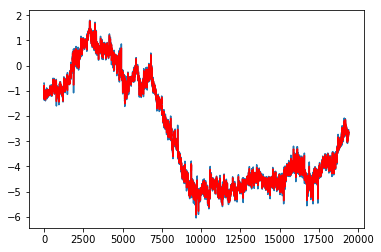

Pair: 2/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  657.624354839325
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                    ARMA(12, 4)   Log Likelihood              380300.364
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 30 Jul 2019   AIC                        -760566.728
Time:                        12:00:28   BIC                        -760395.395
Sample:                             0   HQIC                       -760516.020
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.7370      0.003    240.410      0.000       0.731       0.743
ar.L2.y       -0.0181        nan        nan        nan         nan       

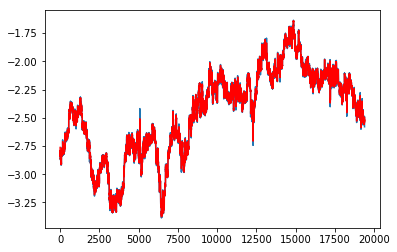

Pair: 3/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  634.6238179206848
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                    ARMA(12, 4)   Log Likelihood              347487.197
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 30 Jul 2019   AIC                        -694940.395
Time:                        12:16:09   BIC                        -694769.063
Sample:                             0   HQIC                       -694889.687
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8195      0.002    401.701      0.000       0.816       0.824
ar.L2.y        0.3740      0.005     76.425      0.000       0.364      

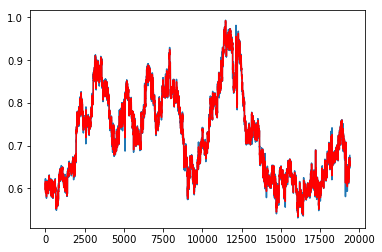

Pair: 4/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  448.0322241783142
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                    ARMA(12, 4)   Log Likelihood              329382.103
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 30 Jul 2019   AIC                        -658730.206
Time:                        12:27:41   BIC                        -658558.874
Sample:                             0   HQIC                       -658679.498
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8658      0.000   4680.326      0.000       0.865       0.866
ar.L2.y        0.0895        nan        nan        nan         nan      

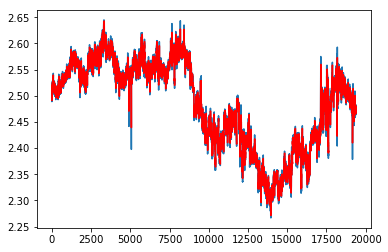

Pair: 5/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  610.8715419769287
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                    ARMA(12, 4)   Log Likelihood              174487.369
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 30 Jul 2019   AIC                        -348940.737
Time:                        12:40:36   BIC                        -348769.405
Sample:                             0   HQIC                       -348890.029
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5218      0.068      7.682      0.000       0.389       0.655
ar.L2.y        0.3887      0.091      4.262      0.000       0.210      

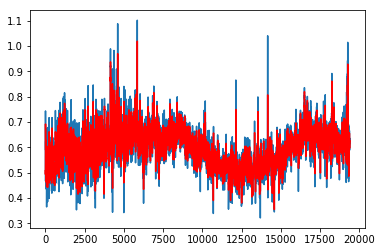

In [625]:
arima_predictions_val, arima_predictions_test = [], []
arima_val, arima_test = [], []
for i, pair in enumerate(pairs):
    sys.stdout.write("\r"+'Pair: {}/{}'.format(i + 1, len(pairs)))
    sys.stdout.flush()
    spread_train = pair[2]['spread']
    spread_test = (pair[2]['Y_test'] - pair[2]['coint_coef']*pair[2]['X_test'])

    pair_predictions_test, pair_predictions_val, error = static_ARIMA(spread_train, spread_test, 12, 0, 4)
    # add predictions
    arima_predictions_val.append(pair_predictions_val)
    arima_predictions_test.append(pair_predictions_test)
    # add spreads
    arima_val.append(spread_train['2017-01-01':])
    arima_test.append(spread_test)    

In [697]:
index = 0
print('ARMA: ', mean_squared_error(arima_test[index], arima_predictions_test[index]))
print('Benchmark: ', mean_squared_error(arima_test[index], 
                                        arima_test[index].shift(1).fillna(0)))

ARMA:  0.009598143171965877
Benchmark:  0.01041369561199642


## Trading with ARMA

In [1154]:
# model to test
low_quantile = 0.10
high_quantile = 0.90

**Validation**

In [1155]:
model_cumret, model_sharpe_ratio = list(), list()
balance_summaries_arma, summaries_arma = list(), list()
for pair_i in range(len(pairs)):
    print('\nPair loaded: {}_{}:'.format(model[pair_i]['leg1'], model[pair_i]['leg2']))
    print('Check pairs: {}_{}.'.format(pairs[pair_i][0], pairs[pair_i][1]))
    predictions = arima_predictions_val[pair_i]
    #predictions = arima_val[pair_i].shift(1).fillna(0)
    spread_train = pairs[pair_i][2]['spread'][:train_val_split]
    spread_val = arima_val[pair_i]
    
    ret, cumret, summary, balance_summary = forecasting_trader.forecast_spread_trading(
                                                        X=pairs[pair_i][2]['X_train'][train_val_split:],
                                                        Y=pairs[pair_i][2]['Y_train'][train_val_split:],
                                                        spread_test=spread_val,#[-len(predictions):],
                                                        spread_train=spread_train,
                                                        beta=pairs[pair_i][2]['coint_coef'],
                                                        predictions=predictions,
                                                        lag=1,
                                                        low_quantile=low_quantile,
                                                        high_quantile=high_quantile,
                                                        multistep=0)
    
    print('Accumulated return: {:.2f}%'.format(cumret[-1] * 100))

    if np.std(ret) != 0:
        sharpe_ratio = trader.calculate_sharpe_ratio(1, 252, ret)
    else:
        sharpe_ratio = 0
    print('Sharpe Ratio:', sharpe_ratio)

    model_cumret.append(cumret[-1] * 100)
    model_sharpe_ratio.append(sharpe_ratio)
    summaries_arma.append(summary)
    balance_summaries_arma.append(balance_summary)

print('\nModel mean ROI: {:.2f}%'.format(np.mean(model_cumret)))
print('Model mean Sharpe Ratio: {:.2f}'.format(np.mean(model_sharpe_ratio)))
performance_arma = [(summaries_arma[i], balance_summaries_arma[i]) for i in range(len(pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_arma, pairs))


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 30.87
Short threshold: -30.28
Accumulated return: -1.66%
Sharpe Ratio: -0.5678216980066089

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.23
Short threshold: -1.25
Accumulated return: 1.48%
Sharpe Ratio: 0.3709541198982

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 5.25
Short threshold: -4.96
Accumulated return: 3.34%
Sharpe Ratio: 0.9113927264682566

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.08
Short threshold: -1.07
Accumulated return: 2.45%
Sharpe Ratio: 0.7919961693181957

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 54.94
Short threshold: -48.31
Accumulated return: 10.09%
Sharpe Ratio: 2.615583052264036

Model mean ROI: 3.14%
Model mean Sharpe Ratio: 0.82
Portfolio Sharpe Ratio:  1.5487607484635613


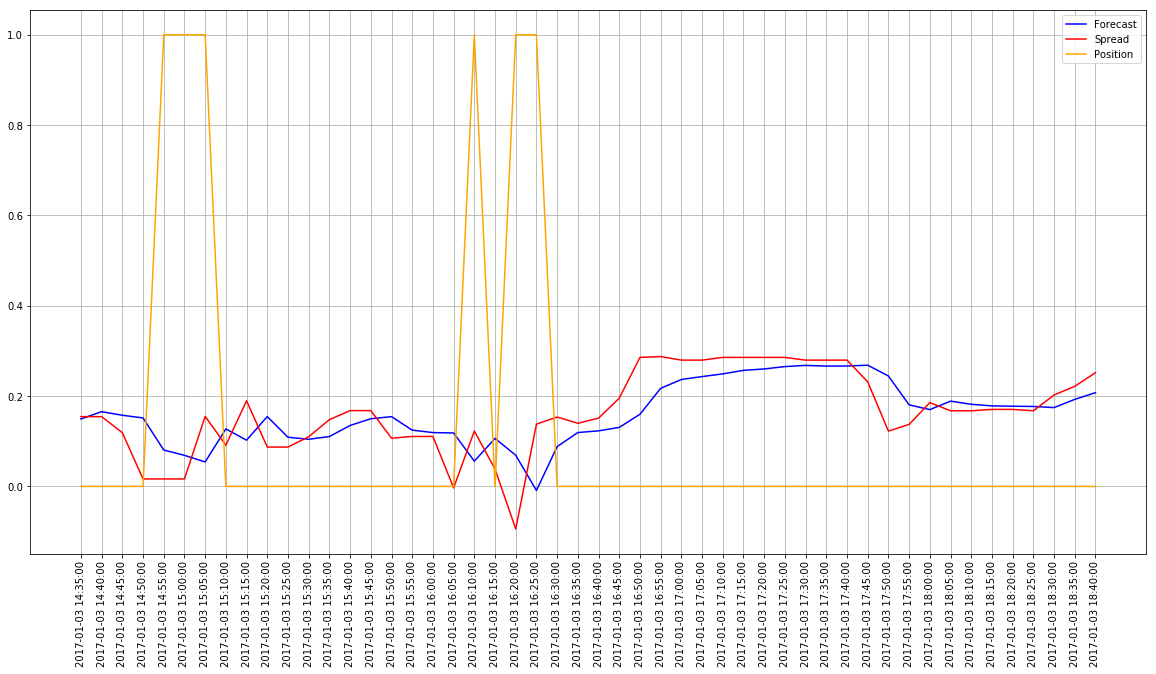

In [1156]:
initial = 0
final=50
sampling = 1
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(summaries_arma[-1]['prediction(t)'].values[initial:final:sampling], color='blue', label='Forecast')
plt.plot(summaries_arma[-1]['spread(t)'].values[initial:final:sampling], color='red', label='Spread')
plt.plot(summaries_arma[-1]['position_during_day'].values[initial:final:sampling], color='orange',
         label='Position')
dates = summaries_arma[0]['prediction(t)'][initial:final:sampling].index[::1]
xi = np.arange(0, len(summaries_arma[-1]['prediction(t)'][initial:final:sampling]), 1)
plt.xticks(xi, dates, rotation=90)
plt.legend()
plt.show()

In [1134]:
summaries_arma[-1]['2017-04-04 19:40:00':'2017-04-05 14:40:00']

,prediction(t),spread(t),spread_predicted_change,position_during_day,PXI,PXE,trading_days,ret_with_costs
2017-04-04 19:40:00,1.769519,1.775347,0.005828,0.0,38.553,20.630,0,0.000000
2017-04-04 19:45:00,1.762903,1.745347,-0.017556,0.0,38.523,20.630,0,0.000000
2017-04-04 19:50:00,1.746259,1.756347,0.010088,0.0,38.534,20.630,0,0.000000
2017-04-04 19:55:00,1.751951,1.755347,0.003396,0.0,38.533,20.630,0,0.000000
2017-04-04 20:00:00,1.750692,1.629640,-0.121053,0.0,38.582,20.728,0,0.000000
2017-04-05 13:35:00,1.655656,2.132760,0.477104,0.0,39.242,20.816,0,0.000000
2017-04-05 13:40:00,2.039548,2.132760,0.093212,1.0,39.242,20.816,0,-0.004371
2017-04-05 13:45:00,2.045563,2.210760,0.165197,1.0,39.320,20.816,0,0.001120
2017-04-05 13:50:00,2.133894,2.368760,0.234866,1.0,39.478,20.816,0,0.002266
2017-04-05 13:55:00,2.255124,2.218760,-0.036364,1.0,39.328,20.816,1,-0.002186


Validation with profitable pairs

In [1080]:
model_cumret = np.asarray(model_cumret)
profitable_pairs_indices = np.argwhere(model_cumret > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]


Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.23
Short threshold: -1.25
Accumulated return: 1.48%
Sharpe Ratio: 0.3709541198982

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 5.25
Short threshold: -4.96
Accumulated return: 3.34%
Sharpe Ratio: 0.9113927264682566

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.08
Short threshold: -1.07
Accumulated return: 2.45%
Sharpe Ratio: 0.7919961693181957

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 54.94
Short threshold: -48.31
Accumulated return: 10.09%
Sharpe Ratio: 2.615583052264036

Model mean ROI: 4.34%
Model mean Sharpe Ratio: 1.17
Portfolio Sharpe Ratio:  2.501257993550183
Max DD period: 4.0 days
Maximum drawdown of portfolio: -0.47%


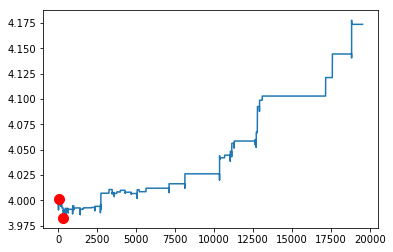

In [901]:
model_cumret, model_sharpe_ratio = list(), list()
balance_summaries_arma, summaries_arma = list(), list()
for pair_i in profitable_pairs_indices.flatten():
    print('\nPair loaded: {}_{}:'.format(model[pair_i]['leg1'], model[pair_i]['leg2']))
    print('Check pairs: {}_{}.'.format(pairs[pair_i][0], pairs[pair_i][1]))
    predictions = arima_predictions_val[pair_i]
    #predictions = arima_val[pair_i].shift(1).fillna(0)
    spread_train = pairs[pair_i][2]['spread'][:train_val_split]
    spread_val = arima_val[pair_i]
    
    ret, cumret, summary, balance_summary = forecasting_trader.forecast_spread_trading(
                                                        X=pairs[pair_i][2]['X_train'][train_val_split:],
                                                        Y=pairs[pair_i][2]['Y_train'][train_val_split:],
                                                        spread_test=spread_val,#[-len(predictions):],
                                                        spread_train=spread_train,
                                                        beta=pairs[pair_i][2]['coint_coef'],
                                                        predictions=predictions,
                                                        lag=1,
                                                        low_quantile=low_quantile,
                                                        high_quantile=high_quantile,
                                                        multistep=0)
    
    print('Accumulated return: {:.2f}%'.format(cumret[-1] * 100))

    if np.std(ret) != 0:
        sharpe_ratio = trader.calculate_sharpe_ratio(1, 252, ret)
    else:
        sharpe_ratio = 0
    print('Sharpe Ratio:', sharpe_ratio)

    model_cumret.append(cumret[-1] * 100)
    model_sharpe_ratio.append(sharpe_ratio)
    summaries_arma.append(summary)
    balance_summaries_arma.append(balance_summary)

print('\nModel mean ROI: {:.2f}%'.format(np.mean(model_cumret)))
print('Model mean Sharpe Ratio: {:.2f}'.format(np.mean(model_sharpe_ratio)))
performance_arma = [(summaries_arma[i], balance_summaries_arma[i]) for i in range(len(profitable_pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_arma, profitable_pairs))

total_account_balance = balance_summaries_arma[0]['account_balance']
for index in range(1, len(profitable_pairs)):
    total_account_balance = total_account_balance + balance_summaries_arma[index]['account_balance']
total_account_balance = total_account_balance.fillna(method='ffill')

print('Maximum drawdown of portfolio: {:.2f}%'.format(trader.calculate_maximum_drawdown(total_account_balance)))

**Test**

In [701]:
model_cumret, model_sharpe_ratio = list(), list()
balance_summaries_arma, summaries_arma = list(), list()
for pair_i in profitable_pairs_indices.flatten():
    print('\nPair loaded: {}_{}:'.format(model[pair_i]['leg1'], model[pair_i]['leg2']))
    print('Check pairs: {}_{}.'.format(pairs[pair_i][0], pairs[pair_i][1]))
    predictions = arima_predictions_test[pair_i]
    spread_train = pairs[pair_i][2]['spread']
    spread_test = arima_test[pair_i]
    
    ret, cumret, summary, balance_summary = forecasting_trader.forecast_spread_trading(
                                                        X=pairs[pair_i][2]['X_test'],
                                                        Y=pairs[pair_i][2]['Y_test'],
                                                        spread_test=spread_test[-len(predictions):],
                                                        spread_train=pairs[pair_i][2]['spread'],
                                                        beta=pairs[pair_i][2]['coint_coef'],
                                                        predictions=predictions,
                                                        lag=1,
                                                        low_quantile=low_quantile,
                                                        high_quantile=high_quantile,
                                                        multistep=0)
    
    print('Accumulated return: {:.2f}%'.format(cumret[-1] * 100))

    if np.std(ret) != 0:
        sharpe_ratio = trader.calculate_sharpe_ratio(1, 252, ret)
    else:
        sharpe_ratio = 0
    print('Sharpe Ratio:', sharpe_ratio)

    model_cumret.append(cumret[-1] * 100)
    model_sharpe_ratio.append(sharpe_ratio)
    summaries_arma.append(summary)
    balance_summaries_arma.append(balance_summary)

print('\nModel mean ROI: {:.2f}%'.format(np.mean(model_cumret)))
print('Model mean Sharpe Ratio: {:.2f}'.format(np.mean(model_sharpe_ratio)))
if len(profitable_pairs)>1:
    performance_arma = [(summaries_arma[i], balance_summaries_arma[i]) for i in range(len(profitable_pairs))]
    print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_arma, profitable_pairs))


Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 2.66
Short threshold: -2.58
Accumulated return: 2.00%
Sharpe Ratio: 0.030103625742899768

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 0.72
Short threshold: -0.71
Accumulated return: 12.76%
Sharpe Ratio: 1.2881846863859496

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 26.51
Short threshold: -23.25
Accumulated return: 1.77%
Sharpe Ratio: -0.1376306294869024

Model mean ROI: 5.51%
Model mean Sharpe Ratio: 0.39
Portfolio Sharpe Ratio:  1.2187670848864263


Max DD period: 22.0 days
Maximum drawdown of portfolio: -0.76%


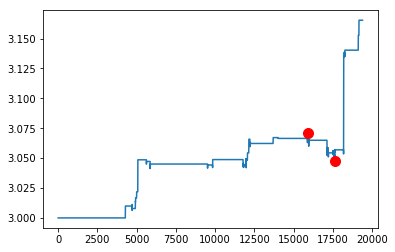

In [702]:
total_account_balance = balance_summaries_arma[0]['account_balance']
for index in range(1, len(profitable_pairs)):
    total_account_balance = total_account_balance + balance_summaries_arma[index]['account_balance']
total_account_balance = total_account_balance.fillna(method='ffill')

print('Maximum drawdown of portfolio: {:.2f}%'.format(trader.calculate_maximum_drawdown(total_account_balance)))

In [703]:
total_trades = 0
positive_trades = 0
negative_trades = 0
for i in range(len(profitable_pairs)):
    total_trades += len(balance_summaries_arma[i][balance_summaries_arma[i].trading_duration != 0])
    # positive & negative
    trading_subset = summaries_arma[i][summaries_arma[i].trading_days != 0]
    positive_trades += len(trading_subset[trading_subset.position_return > 0])
    negative_trades += len(trading_subset[trading_subset.position_return <= 0])
print('Total number of trades: ',total_trades)
print('Positive trades: ',positive_trades)
print('Negative trades: ',negative_trades)

Total number of trades:  34
Positive trades:  30
Negative trades:  4


# Trying some ANN based models

In [883]:
def plot_loss(history, title, epoch_stop, metric='mse'):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    plt.figure(figsize=(7,5))
    plt.grid()
    if metric == 'mse':
        plt.plot(history['loss'], label = "Training MSE")
        plt.plot(history['val_loss'], label = "Validation MSE")
        plt.plot([epoch_stop], [history['val_loss'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MSE:{:.3f}'.format(history['val_loss'][epoch_stop]),
            xy=(epoch_stop, history['val_loss'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Squared Error', size=12)
    elif metric == 'mae':
        plt.plot(history['mean_absolute_error'], label = "Training MAE")
        plt.plot(history['val_mean_absolute_error'], label = "Validation MAE")
        plt.plot([epoch_stop], [history['val_mean_absolute_error'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MAE:{:.3f}'.format(history['val_mean_absolute_error'][epoch_stop]),
            xy=(epoch_stop, history['val_mean_absolute_error'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Absolute Error', size=12)
    plt.xlabel('Epochs', size=12)
    plt.legend()
    plt.savefig('{}_history.png'.format(metric), bbox='tight')
    
def plot_predictions(summaries):
    
    n_pairs = len(summaries)
    fig, ax = plt.subplots(n_pairs, 1, figsize=(20,25))
    
    for i in range(n_pairs):
        #title('Pair: {}'.format(i))
        predictions = summaries[i]['prediction(t)']
        spread = summaries[i]['spread(t)']
        ax[i].plot(predictions, 'b')
        ax[i].plot(spread, 'r')
    return None

**Load models run in the server**

In [734]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

## RNN

## Grid Search

In [1157]:
current_path=('models_copy/rnn_5_pairs_optical/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

5

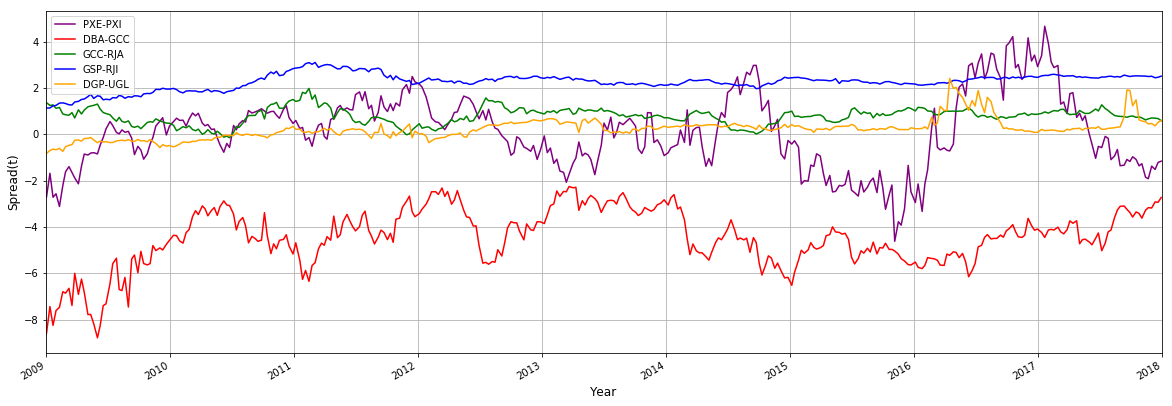

In [1158]:
#markers= ["o","s","+","x","<"]
colors = ['purple', 'r', 'g', 'blue', 'orange']
for i in range(len(pairs)):
    pairs[i][2]['spread'][::500].plot(figsize=(20,7), grid=True, label='{}-{}'.format(pairs[i][0],pairs[i][1]),
                                       c=colors[i])#,marker=markers[i])
plt.ylabel('Spread(t)',size=12)
plt.xlabel('Year',size=12)
plt.xlim(('2009', '2018'))
plt.legend()

In [1159]:
rnn_models = read_models(path=current_path)

In [1160]:
# model to test
n_in = 24
hidden_nodes = [10]
low_quantile = 0.10
high_quantile = 0.90

**Validation**

In [1161]:
model, cumret_val, summaries_rnn, balance_summaries_rnn = \
            forecasting_trader.run_specific_model(n_in, hidden_nodes, pairs,
                                                  path=current_path,
                                                  low_quantile=low_quantile, high_quantile=high_quantile, lag=1)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_rnn, pairs))


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 30.87
Short threshold: -30.28
Accumulated return: 5.27%
Sharpe Ratio: 1.0658066703430273

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.23
Short threshold: -1.25
Accumulated return: -6.64%
Sharpe Ratio: -1.9185151571177117

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 5.25
Short threshold: -4.96
Accumulated return: 2.81%
Sharpe Ratio: 0.8746688054966582

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.08
Short threshold: -1.07
Accumulated return: 0.20%
Sharpe Ratio: -0.7388213866791108

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 54.94
Short threshold: -48.31
Accumulated return: 16.00%
Sharpe Ratio: 2.9243412840687273

Model mean ROI: 3.53%
Model mean Sharpe Ratio: 0.44
Portfolio Sharpe Ratio:  1.6725168023590145


In [975]:
index = 0
print('RNN: ', mean_squared_error(summaries_rnn[index]['spread(t)'], summaries_rnn[index]['prediction(t)']))
print('Benchmark: ', mean_squared_error(summaries_rnn[index]['spread(t)'], 
                                      summaries_rnn[index]['spread(t)'].shift(1).fillna(0)))

RNN:  0.005702805066566937
Benchmark:  0.005583440703337607


**Test unrestricted**

In [982]:
model, cumret_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=range(len(pairs)))
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_rnn, pairs))    


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 30.16
Short threshold: -29.87
Accumulated return: 1.76%
Sharpe Ratio: -0.026271859487251355

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.19
Short threshold: -1.20
Accumulated return: -5.83%
Sharpe Ratio: -1.2387446233771877

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 4.96
Short threshold: -4.68
Accumulated return: 0.08%
Sharpe Ratio: -23.47151567510794

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.05
Short threshold: -1.04
Accumulated return: 1.82%
Sharpe Ratio: -0.06150526028274873

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 52.17
Short threshold: -44.82
Accumulated return: 0.00%
Sharpe Ratio: 0

Model mean ROI on test set: -0.43%
Model mean Sharpe Ratio on test set: -4.96
Portfolio Sharpe Ratio:  -1.242690940942351


Max DD period: 173.0 days
Maximum drawdown of portfolio: -9.25%


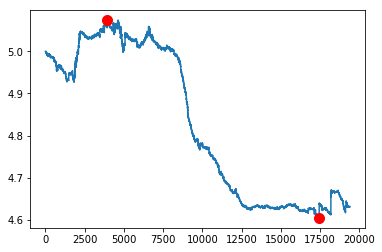

In [686]:
total_account_balance = balance_summaries_rnn[0]['account_balance']
for index in range(1, len(pairs)):
    total_account_balance = total_account_balance + balance_summaries_rnn[index]['account_balance']
total_account_balance = total_account_balance.fillna(method='ffill')

print('Maximum drawdown of portfolio: {:.2f}%'.format(trader.calculate_maximum_drawdown(total_account_balance)))

In [687]:
index = 0
print('RNN: ', mean_squared_error(summaries_rnn[index]['spread(t)'], summaries_rnn[index]['prediction(t)']))
print('Benchmark: ', mean_squared_error(summaries_rnn[index]['spread(t)'], 
                                      summaries_rnn[index]['spread(t)'].shift(1).fillna(0)))

RNN:  0.025619055108658174
Benchmark:  0.010479502439246153


**Test with active pairs on validation set**

We can select top pairs from validation set as we wish.

In [984]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model, cumret, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(profitable_pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_rnn, profitable_pairs)) 


Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 4.96
Short threshold: -4.68
Accumulated return: 0.08%
Sharpe Ratio: -23.47151567510794

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 52.17
Short threshold: -44.82
Accumulated return: 0.00%
Sharpe Ratio: 0

Model mean ROI on test set: 0.04%
Model mean Sharpe Ratio on test set: -11.74
Portfolio Sharpe Ratio:  -47.84507505432159


Max DD period: 5.0 days
Maximum drawdown of portfolio: -1.50%


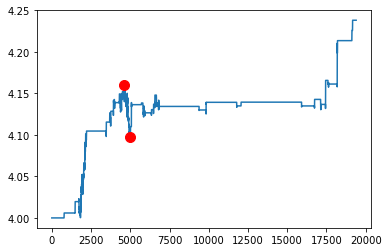

In [689]:
total_account_balance = balance_summaries_rnn[0]['account_balance']
for index in range(1, len(profitable_pairs)):
    total_account_balance = total_account_balance + balance_summaries_rnn[index]['account_balance']
total_account_balance = total_account_balance.fillna(method='ffill')

print('Maximum drawdown of portfolio: {:.2f}%'.format(trader.calculate_maximum_drawdown(total_account_balance)))

In [690]:
total_trades = 0
positive_trades = 0
negative_trades = 0
for i in range(len(profitable_pairs)):
    total_trades += len(balance_summaries_rnn[i][balance_summaries_rnn[i].trading_duration != 0])
    # positive & negative
    trading_subset = summaries_rnn[i][summaries_rnn[i].trading_days != 0]
    positive_trades += len(trading_subset[trading_subset.position_return > 0])
    negative_trades += len(trading_subset[trading_subset.position_return <= 0])
print('Total number of trades: ',total_trades)
print('Positive trades: ',positive_trades)
print('Negative trades: ',negative_trades)

Total number of trades:  73
Positive trades:  61
Negative trades:  12


## Encoder-Decoder LSTM Multi-step Forecasting

### Grid Search

In [985]:
current_path=('models_copy/encoder_decoder_5_optical/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

5

In [986]:
models = read_models(current_path)

In [987]:
# model to test
n_in = 24
hidden_nodes = [10, 10]
low_quantile = 0.10
high_quantile = 0.90

In [988]:
model, cumret_val, summaries_encdec, balance_summaries_encdec = \
            forecasting_trader.run_specific_model(n_in, hidden_nodes, pairs,
                                                  path=current_path,
                                                  low_quantile=low_quantile, high_quantile=high_quantile,
                                                  lag=1, multistep=1)
performance_encdec = [(summaries_encdec[i], balance_summaries_encdec[i]) for i in range(len(pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_encdec, pairs))


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 35.36
Short threshold: -34.93
Accumulated return: -1.05%
Sharpe Ratio: -0.4684107710007779

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.52
Short threshold: -1.54
Accumulated return: -0.06%
Sharpe Ratio: -0.3376199332710901

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 5.93
Short threshold: -5.52
Accumulated return: 3.24%
Sharpe Ratio: 1.0596771603658839

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.25
Short threshold: -1.23
Accumulated return: 2.63%
Sharpe Ratio: 0.8576901887580555

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 55.84
Short threshold: -47.85
Accumulated return: 11.70%
Sharpe Ratio: 2.9751603233265245

Model mean ROI: 3.29%
Model mean Sharpe Ratio: 0.82
Portfolio Sharpe Ratio:  1.6559848237040955


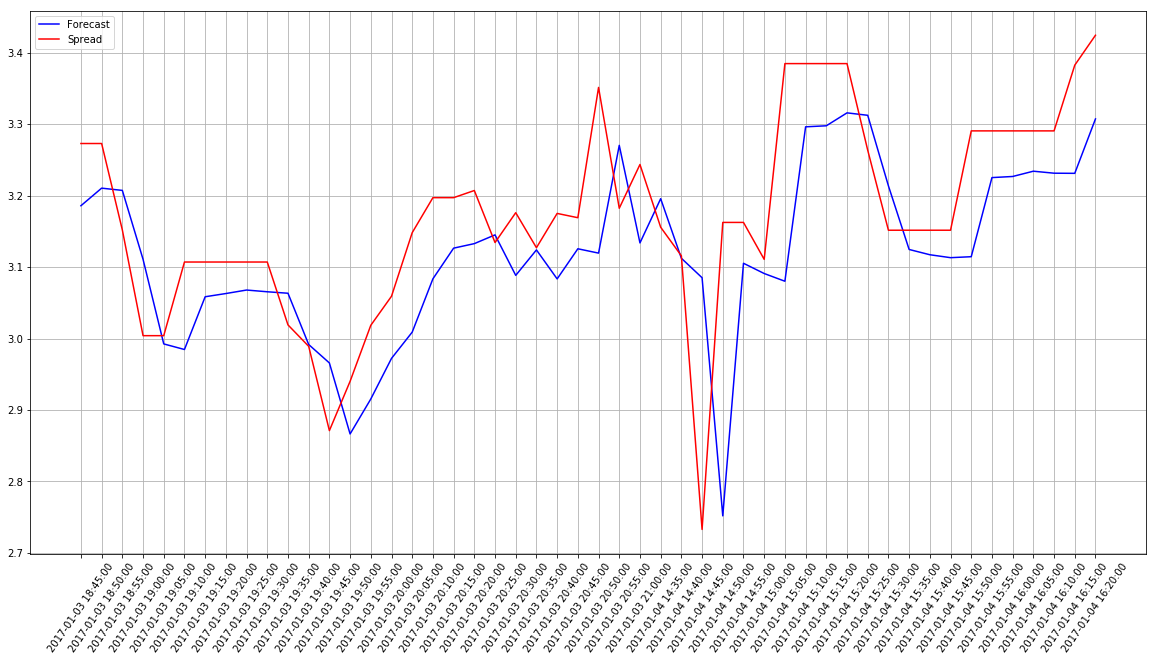

In [1051]:
initial = 50
final=100
sampling = 1
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(summaries_encdec[0]['prediction(t)'].values[initial:final:sampling], color='blue', label='Forecast')
plt.plot(summaries_encdec[0]['spread(t)'].values[initial:final:sampling], color='red', label='Spread')
dates = summaries_encdec[0]['prediction(t)'][initial:final:sampling].index[::1]
xi = np.arange(0, len(summaries_encdec[0]['prediction(t)'][initial:final:sampling]), 1)
plt.xticks(xi, dates, rotation=55)
plt.legend()
plt.show()

In [ ]:
encoder_decoder_trainer.py_decoder_trainer.py

## Result for thesis

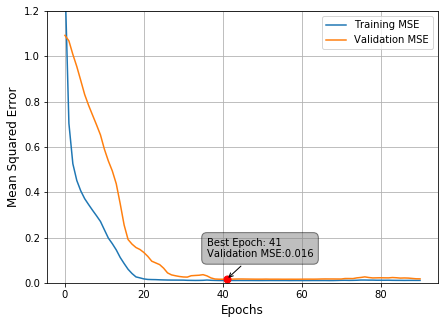

In [884]:
i = 4
plot_loss(model[i]['history'], 'Loss history from {}-{} spread training'.format(pairs[i][0], pairs[i][1]),
         epoch_stop = model[i]['epoch_stop'], metric='mse')

Loss history from DGP-UGL spread training


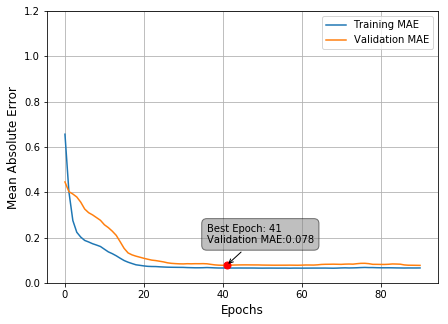

In [881]:
i = 4
print('Loss history from {}-{} spread training'.format(pairs[i][0], pairs[i][1]))
plot_loss(model[i]['history'], 'Loss history from {}-{} spread training'.format(pairs[i][0], pairs[i][1]),
         epoch_stop = model[i]['epoch_stop'], metric='mae')

In [ ]:
index = 0
summaries_encdec[index]['spread(t)'].plot(c='r')
summaries_encdec[index]['prediction(t)'].plot(figsize=(15,10), c='b', grid=True)
#summaries_encdec[index]['prediction(t+1)'].plot(figsize=(15,10), c='y', grid=True)

print('EncDec: ',mean_squared_error(summaries_encdec[index]['spread(t)'],summaries_encdec[index]['prediction(t)']))
print('Benchmark: ',mean_squared_error(summaries_encdec[index]['spread(t)'],
                                       summaries_encdec[index]['spread(t)'].shift(1).fillna(0)))

**Test Unrestricted**

In [907]:
model, cumret_val, summaries_encdec, balance_summaries_encdec = \
            forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs,
                                                  path=current_path,
                                                  low_quantile=low_quantile, high_quantile=high_quantile,
                                                  lag=1, multistep=1, profitable_pairs_indices=range(len(pairs)))
performance_encdec = [(summaries_encdec[i], balance_summaries_encdec[i]) for i in range(len(pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_encdec, pairs))


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 34.22
Short threshold: -34.26
Accumulated return: 2.41%
Sharpe Ratio: 0.07268280511402561

Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 1.47
Short threshold: -1.49
Accumulated return: -3.78%
Sharpe Ratio: -0.8464600119837272

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 5.52
Short threshold: -5.16
Accumulated return: 2.30%
Sharpe Ratio: 0.09994693109292974

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.21
Short threshold: -1.19
Accumulated return: 10.20%
Sharpe Ratio: 1.476080410741228

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 53.23
Short threshold: -44.21
Accumulated return: 0.00%
Sharpe Ratio: 0

Model mean ROI on test set: 2.23%
Model mean Sharpe Ratio on test set: 0.16
Portfolio Sharpe Ratio:  0.11712568961614665


Max DD period: 84.0 days
Maximum drawdown of portfolio: -1.64%


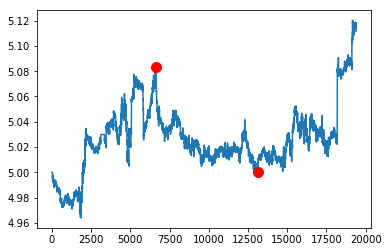

In [908]:
total_account_balance = balance_summaries_encdec[0]['account_balance']
for index in range(1, len(pairs)):
    total_account_balance = total_account_balance + balance_summaries_encdec[index]['account_balance']
total_account_balance = total_account_balance.fillna(method='ffill')

print('Maximum drawdown of portfolio: {:.2f}%'.format(trader.calculate_maximum_drawdown(total_account_balance)))

**Active pairs during validation**

In [757]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
_, _, summaries_encdec, balance_summaries_encdec = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               multistep=1,
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_encdec = [(summaries_encdec[i], balance_summaries_encdec[i]) for i in range(len(profitable_pairs))]
print('Portfolio Sharpe Ratio: ',trader.calculate_portfolio_sharpe_ratio(performance_encdec, profitable_pairs))


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 34.22
Short threshold: -34.26
Accumulated return: 13.01%
Sharpe Ratio: 1.714521884473042

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 5.52
Short threshold: -5.16
Accumulated return: 2.71%
Sharpe Ratio: 0.48927915838637714

Pair loaded: GSP_RJI:
Check pairs: GSP_RJI.
Long threshold: 1.21
Short threshold: -1.19
Accumulated return: 8.37%
Sharpe Ratio: 1.0670662088144727

Model mean ROI on test set: 8.03%
Model mean Sharpe Ratio on test set: 1.09
Portfolio Sharpe Ratio:  1.9896199885244725


Max DD period: 4.0 days
Maximum drawdown of portfolio: -1.55%


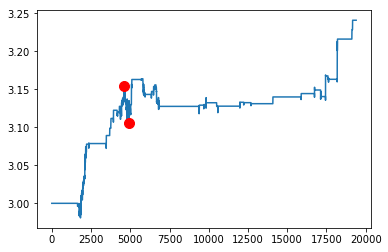

In [758]:
total_account_balance = balance_summaries_encdec[0]['account_balance']
for index in range(1, len(profitable_pairs)):
    total_account_balance = total_account_balance + balance_summaries_encdec[index]['account_balance']
total_account_balance = total_account_balance.fillna(method='ffill')

print('Maximum drawdown of portfolio: {:.2f}%'.format(trader.calculate_maximum_drawdown(total_account_balance)))

In [759]:
total_trades = 0
positive_trades = 0
negative_trades = 0
for i in range(len(profitable_pairs)):
    total_trades += len(balance_summaries_encdec[i][balance_summaries_encdec[i].trading_duration != 0])
    # positive & negative
    trading_subset = summaries_encdec[i][summaries_encdec[i].trading_days != 0]
    positive_trades += len(trading_subset[trading_subset.position_return > 0])
    negative_trades += len(trading_subset[trading_subset.position_return <= 0])
print('Total number of trades: ',total_trades)
print('Positive trades: ',positive_trades)
print('Negative trades: ',negative_trades)

Total number of trades:  106
Positive trades:  85
Negative trades:  21


# Comparing Neural Networks

In [239]:
current_path=('models_copy/rnn_5_pairs_optical/')
rnn_models = read_models(path=current_path)
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

model_i = 0
print(rnn_models[model_i][-1])
for pair_i in range(5):
    predictions_val = rnn_models[model_i][pair_i]['predictions_val']
    spread_val = pairs[pair_i][2]['spread'][train_val_split:]
    print('Pair {}-{}: Val RMSE: {}E-3; Accuracy: {}%'.format(pairs[pair_i][0], pairs[pair_i][1], 
                                           np.sqrt(mean_squared_error(predictions_val, spread_val))*1000,
                                           forecasting_trader.calculate_direction_accuracy(spread_val,
                                                                                           predictions_val)))

{'n_in': 12, 'n_out': 1, 'epochs': 250, 'hidden_nodes': [10], 'loss_fct': 'mse', 'optimizer': 'adam', 'batch_size': 1024, 'train_val_split': '2017-01-01', 'test_init': '2018-01-01'}
Pair PXE-PXI: Val RMSE: 104.41480033583048E-3; Accuracy: 18.732697631498%
Pair DBA-GCC: Val RMSE: 20.25690867390696E-3; Accuracy: 34.051061211934794%
Pair GCC-RJA: Val RMSE: 7.738687580928983E-3; Accuracy: 17.527940120988415%
Pair GSP-RJI: Val RMSE: 7.311287943687445E-3; Accuracy: 16.338562493591716%
Pair DGP-UGL: Val RMSE: 46.95296630146496E-3; Accuracy: 23.41843535322465%


### Observations

- The simpler the algorithm the better the score. But the score by itself seems not to be strictly related with returns. It is however a way to evaluate the forecasting ability of the algorithms.

## Supporting the benchmark model with predictions

In [ ]:
# no support

In [545]:
results_without_costs, results_with_costs, performance_threshold_test = trader.apply_trading_strategy(pairs,
                                                                                             'fixed_beta',
                                                                                             1.5,
                                                                                             0,
                                                                                             test_mode=True)
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

_, _, _, _ = trader.calculate_metrics(sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs,
                                      1)

Pair: 5/5Average result:  2.2072976898033496
avg_annual_roi:  26.72258556181264
100.0 % of the pairs had positive returns


In [474]:
# with support

In [549]:
# append predictions to pairs
for i in range(len(pairs)):
    pairs[i][2]['predictions'] = summaries_rnn[i]['spread(t)'] #summaries_rnn[i]['prediction(t)']
    
# run again with deep learning flag
results_without_costs, results_with_costs, performance_threshold_test = trader.apply_trading_strategy(pairs,
                                                                                             'fixed_beta',
                                                                                             1.5,
                                                                                             0,
                                                                                             test_mode=True,
                                                                                             ai_support=True
                                                                                            )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

_, _, _, _ = trader.calculate_metrics(sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs,
                                      1)

Pair: 5/5Average result:  2.258588850817274
avg_annual_roi:  28.694686301384962
100.0 % of the pairs had positive returns


In [550]:
performance_threshold_test[0][1]['2018-02-26']#[performance_threshold_test[0][1].position_during_day != 0]

,pnl,pnl_y,pnl_x,account_balance,returns,position_return,prediction_change,PXI,PXE,norm_spread,position_during_day,trading_duration,position_ret_with_costs
2018-02-26 14:35:00,0.003827,-0.004436,0.008263,0.963026,0.003989,0.0,-0.009325,38.021,20.553,1.910642,-1.0,0,0.0
2018-02-26 14:40:00,-0.006638,-0.000000,-0.006638,0.956388,-0.006893,0.0,0.254930,38.021,20.410,2.030490,-1.0,0,0.0
2018-02-26 14:45:00,0.000000,-0.000000,0.000000,0.956388,0.000000,0.0,0.000000,38.021,20.410,2.030490,-1.0,0,0.0
2018-02-26 14:50:00,-0.002089,-0.000000,-0.002089,0.954299,-0.002184,0.0,0.080223,38.021,20.365,2.068204,-1.0,0,0.0
2018-02-26 14:55:00,0.000000,-0.000000,0.000000,0.954299,0.000000,0.0,0.000000,38.021,20.365,2.068204,-1.0,0,0.0
2018-02-26 15:00:00,0.000000,-0.000000,0.000000,0.954299,0.000000,0.0,0.000000,38.021,20.365,2.068204,-1.0,0,0.0
2018-02-26 15:05:00,0.000000,-0.000000,0.000000,0.954299,0.000000,0.0,0.000000,38.021,20.365,2.068204,-1.0,0,0.0
2018-02-26 15:10:00,0.000000,-0.000000,0.000000,0.954299,0.000000,0.0,0.000000,38.021,20.365,2.068204,-1.0,0,0.0
2018-02-26 15:15:00,-0.001346,-0.000000,-0.001346,0.952953,-0.001411,0.0,0.051699,38.021,20.336,2.092509,-1.0,0,0.0
2018-02-26 15:20:00,0.000000,-0.000000,0.000000,0.952953,0.000000,0.0,0.000000,38.021,20.336,2.092509,-1.0,0,0.0


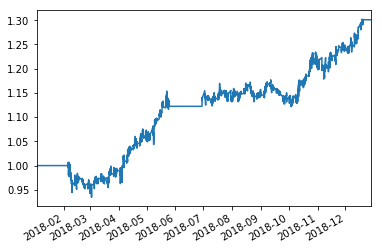

In [551]:
performance_threshold_test[0][1].account_balance.plot()#['2018-05-29 15:50:00':'2018-05-30']#[performance_threshold_test[2][1].position_during_day!=0]

# Comparing the three forecasting models

## Validation forecasting error

In [965]:
def evaluate_forecasting(n_pairs, true_values, prediction_values):
    mse, mae, rmse, accuracy, bias = list(), list(), list(), list(), list()
    std_dev = list()
    for i in range(n_pairs):
        mse.append(mean_squared_error(true_values[i], prediction_values[i]))
        rmse.append(np.sqrt(mean_squared_error(true_values[i], prediction_values[i])))
        mae.append(mean_absolute_error(true_values[i], prediction_values[i]))
        accuracy.append(forecasting_trader.calculate_direction_accuracy(true_values[i], prediction_values[i]))
        bias.append((true_values[i] - prediction_values[i]).mean())
        std_dev.append(prediction_values[i].std())
    print('Average MSE: {:.2f}E-4'.format(np.mean(mse)*10000))
    print('Average RMSE: {:.2f}E-3'.format(np.mean(rmse)*1000))
    print('Average MAE: {:.2f}E-3'.format(np.mean(mae)*1000))
    print('Average Directional Accuracy: {:.2f}%'.format(np.mean(accuracy)))
    print('Bias: {:.2f}E-4'.format(np.mean(bias)*10000))
    print('Average Standard Deviation from prediction signal ', np.mean(std_dev))
    
    return mse, mae, rmse, accuracy

Naive:

In [743]:
predictions_naive = [arima_val[i].shift(1).fillna(0) for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), arima_val, predictions_naive)

Average MSE: 18.67E-4
Average RMSE: 36.86E-3
Average MAE: 15.03E-3
Average Directional Accuracy: 23.37%
Bias: -0.04E-4


ARMA:

In [942]:
_ = evaluate_forecasting(len(pairs), arima_val, arima_predictions_val)

Average MSE: 14.93E-4
Average RMSE: 29.88E-3
Average MAE: 17.61E-3
Average Directional Accuracy: 39.12%
Bias: 0.02E-4
Average Standard Deviation from prediction signal  [1.7909509404904647, 0.586058524721636, 0.14922252706579997, 0.039661783105034445, 0.4308558690946126]


LSTM

In [747]:
true_val = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

Average MSE: 31.54E-4
Average RMSE: 42.64E-3
Average MAE: 21.49E-3
Average Directional Accuracy: 39.51%
Bias: 4.00E-4


Encoder Decoder

In [943]:
true_val = [summaries_encdec[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

Average MSE: 20.78E-4
Average RMSE: 35.39E-3
Average MAE: 23.31E-3
Average Directional Accuracy: 39.86%
Bias: -9.43E-4
Average Standard Deviation from prediction signal  [1.7548466920852661, 0.5712736248970032, 0.14739985764026642, 0.040482137352228165, 0.426640123128891]


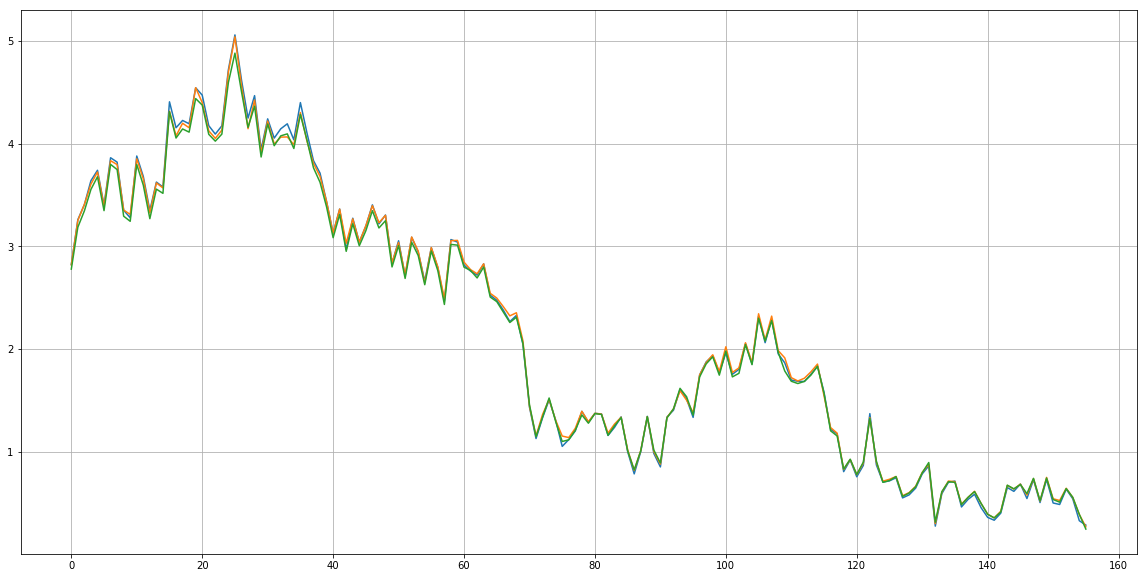

In [544]:
sampling = 50
xmax = 100*78
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(arima_predictions_val[0].values[:xmax:sampling])
plt.plot(summaries_rnn[0]['prediction(t)'].values[:xmax:sampling])
plt.plot(summaries_encdec[0]['prediction(t)'].values[:xmax:sampling])

## Test forecasting error

Naive:

In [580]:
predictions_naive = [arima_test[i].shift(1).fillna(0) for i in range(len(pairs))]
evaluate_forecasting(len(pairs), arima_test, predictions_naive)

Average MSE: 25.96E-4
Average RMSE: 38.87E-3
Average MAE: 16.79E-3
Average Directional Accuracy: 23.63%
Bias: -0.14E-4


ARMA:

In [628]:
evaluate_forecasting(len(pairs), arima_test, arima_predictions_test)

Average MSE: 22.64E-4
Average RMSE: 33.38E-3
Average MAE: 19.64E-3
Average Directional Accuracy: 40.33%
Bias: -0.95E-4


LSTM:

In [983]:
true_val = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

Average MSE: 84.48E-4
Average RMSE: 62.86E-3
Average MAE: 41.03E-3
Average Directional Accuracy: 42.44%
Bias: -25.17E-4
Average Standard Deviation from prediction signal  0.5333357870578765


Encoder Decoder:

In [910]:
true_val = [summaries_encdec[i]['spread(t)'].shift(1).fillna(method='bfill') for i in range(len(pairs))]
#predictions = [summaries_encdec[i]['prediction(t)'] for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t+1)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

Average MSE: 90.25E-4
Average RMSE: 75.02E-3
Average MAE: 59.09E-3
Average Directional Accuracy: 40.65%
Bias: 264.80E-4


In [781]:
true_val = [summaries_encdec[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

Average MSE: 171.19E-4
Average RMSE: 80.63E-3
Average MAE: 56.51E-3
Average Directional Accuracy: 41.81%
Bias: -207.75E-4
